# Exploring the Te Papa collection API

Te Papa has a [new collection API](https://data.tepapa.govt.nz/docs/index.html), so I thought I should have a poke around. This notebook is just a preliminary exploration — it's not intended as a tutorial or a guide. There may well be mistakes and misinterpretations. Nonetheless, it might help you get a feel for what's possible.

In the future I'll add notebooks focused on specific tasks, but for now we're just going to follow our noses and see where we end up.

<div class="alert alert-block alert-warning">
<p>If you haven't used one of these notebooks before, they're basically web pages in which you can write, edit, and run live code. They're meant to encourage experimentation, so don't feel nervous. Just try running a few cells and see what happens!.</p>

<p>
    Some tips:
    <ul>
        <li>Code cells have boxes around them. When you hover over them a <i class="fa-step-forward fa"></i> icon appears.</li>
        <li>To run a code cell either click the <i class="fa-step-forward fa"></i> icon, or click on the cell and then hit <b>Shift+Enter</b>. The <b>Shift+Enter</b> combo will also move you to the next cell, so it's a quick way to work through the notebook.</li>
        <li>While a cell is running a <b>*</b> appears in the square brackets next to the cell. Once the cell has finished running the asterix will be replaced with a number.</li>
        <li>In most cases you'll want to start from the top of notebook and work your way down running each cell in turn. Later cells might depend on the results of earlier ones.</li>
        <li>To edit a code cell, just click on it and type stuff. Remember to run the cell once you've finished editing.</li>
    </ul>
</p>
</div>

In [254]:
import requests
import pandas as pd
import altair as alt
from tqdm import tnrange
import re
from six import iteritems
from IPython.display import display, HTML
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Get an API key

[Sign up here](https://data.tepapa.govt.nz/docs/register.html) for your very own API key. The cell below will try and use the guest token if no key is supplied, but this doesn't seem to be working at the moment. If you get an error when you make an API request, go and get your own key.

In [308]:
api_key = ''
# Insert your API key between the quotes
#api_key = ''
# If you don't have an API key yet, you could leave the above blank and try to use a guest key
if not api_key:
    response = requests.get('https://data.tepapa.govt.nz/collection/search')
    data = response.json()
    api_key = data['guestToken']
print('Your API key is: {}'.format(api_key))

Your API key is: Q0kiSaBk5excMZ2ixnzsiXl1MsP0moqHWRT259vt


In [300]:
search_endpoint = 'https://data.tepapa.govt.nz/collection/search'
object_endpoint = 'https://data.tepapa.govt.nz/collection/object'
endpoint = 'https://data.tepapa.govt.nz/collection/{}'
headers = {
    'x-api-key': api_key,
    'Accept': 'application/json'
}

## What will we search for?

Here's I'm going to set a keyword that I'll use in my searches throughout this notebook. Feel free to change it to explore your own results. You can also set it to '\*' (an asterix) to return everything.

In [301]:
keyword = 'Chinese'

## Let's make our first API request!

In [302]:
# Set our search parameters for passing to Requests
params = {
    'q': keyword
}

In [303]:
# Send off the API request
# We need to supply the `headers` to authenticate our request with our key
response = requests.get(search_endpoint, headers=headers, params=params)
# Get the JSON result data
data = response.json()

In [304]:
# Drill down to get the summary data from our search
data['_metadata']['resultset']

{'count': 11852, 'from': 0, 'size': 100, 'truncated': False}

In [261]:
print('Your search for "{}" using the Te Papa collection API returned {:,} results.'.format(keyword, data['_metadata']['resultset']['count']))

Your search for "Chinese" using the Te Papa collection API returned 11,852 results.


## What sorts of things are in our search results?

A really useful feature of the API is that you can ask for facets on lots of different fields. You've probably used the facets on the [Te Papa collection search page](https://collections.tepapa.govt.nz/) to narrow down your results. Using the API, you can go even further, using the facets to summarise your results from a variety of different angles.

Let's start by getting facets from the `type` field. To request facets you have to POST your query to the [search endpoint](https://data.tepapa.govt.nz/docs/resource_SearchResource.html). Fortunately the Python Requests library makes it really easy to create and submit POST requests. All you have to do is supply the name of the field you want facets for, and the number of facets to return. If you set `size` to `5`, you'll get the 5 most frequent values. According to some ElasticSearch docs I found, you should be able to get all the facets by setting `size` to `0` (ie zero), but I couldn't get this to work.

#### Create POST request data

In [262]:
# This is the dictionary that provides the data for the POST request
# Here we're saying we want the 5 'types' with the most results
# You can change the size parameter as necessary.

post_data = {
    'query': 'chinese',
    'facets': [
        {
            'field': 'type',
            'size': 5
        }
    ]
}

#### Make the API request

Note that we're using the `post` method rather than `get`. If we supply the POST data using the `json` parameter, Requests takes care of all the tricky encoding issues.

In [263]:
response = requests.post(search_endpoint, json=post_data, headers=headers)
data = response.json()

#### Convert to a dataframe

Let's convert the results to a Pandas dataframe because Pandas is awesome and it'll make it easier to create charts.

In [264]:
types_df = pd.DataFrame(list(data['facets']['type'].items()))
# Set columns names
types_df.columns = ['Type', 'Count']

In [265]:
# View the results
types_df

,Type,Count
0,Specimen,83
1,Category,121
2,Object,11451
3,Topic,26
4,Place,134


#### Display the results as a bar chart

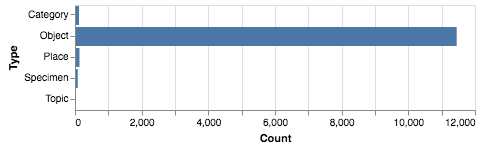

In [266]:
alt.Chart(types_df).mark_bar().encode(
    y='Type:O',
    x='Count',
    tooltip=[alt.Tooltip('Type:O'), alt.Tooltip('Count')]
)

## What collections are the objects in?

One of the great things about the Te Papa API is the richness of the data and all the interrelations between things, people, places, and subjects. But this also makes it a bit of a challenge to understand how everything fits together. On the GitHub site there's a useful summary of the record structures used to represent the different types of things. Here, for example, is what an [object record](https://github.com/te-papa/collections-api/wiki/Collections-API-Object-Model#object) looks like. Using this as a guide we can start to dig down through the data.

Let's get an overview of the `objects` in our search results by using the `collection` facet.

#### Create the POST request data

This time we're using the `filters` parameter to limit our search to things that have the `type` of 'Object'. We're then getting facets on the `collection` field.

Instead of using `filters` we could include something like `type: Object` in the query string. I think this changes the way the result set is constructed, but I don't know if it affects the results returned.

In [267]:
post_data = {
    'query': 'chinese',
    'filters': [{
        'field': 'type',
        'keyword': 'Object'
    }],
    'facets': [
        {'field': 'collection',
        'size': 20}
    ]
}

#### Make the API request and convert the results to a dataframe

In [268]:
# Get the API response
response = requests.post(search_endpoint, json=post_data, headers=headers)
data = response.json()

In [269]:
# Convert to a dataframe
objects_df = pd.DataFrame(list(data['facets']['collection'].items()))
objects_df.columns = ['Collection', 'Count']

In [270]:
# View the results
objects_df

,Collection,Count
0,Photography,8920
1,MuseumArchives,7
2,Art,86
3,CollectedArchives,109
4,Philatelic,73
5,TaongaMāori,4
6,RareBooks,8
7,PacificCultures,29
8,History,2215


#### Display the results as a bar chart

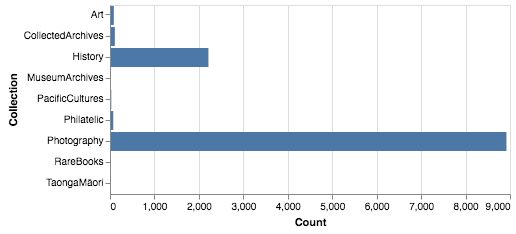

In [271]:
alt.Chart(objects_df).mark_bar().encode(
    y='Collection:O',
    x='Count',
    tooltip=[alt.Tooltip('Collection:O'), alt.Tooltip('Count')]
)

So there's **lots** of photos. Let's see what we can find out about them.

## When were the photos taken?

As well as examining categories, we can use facets to display the date range of the results. But what date, and where is it? If you look at the structure of an [object record](https://github.com/te-papa/collections-api/wiki/Collections-API-Object-Model#object), you'll see that the `production` field is actually a list of production 'events' which have a `creationDate` field. In order to get a list of facets for `createdDate` we have to use dot notation to move down through the record hierarchy — so the field for faceting is `production.createdDate`.

#### The POST data

In [309]:
post_data = {
    'query': 'chinese',
    'filters': [{
        'field': 'collection',
        'keyword': 'Photography'
    }],
    'facets': [
        {'field': 'production.createdDate',
        'size': 100}
    ]
}

#### The API request and response

In [310]:
# Get the API response
response = requests.post(search_endpoint, json=post_data, headers=headers)
data = response.json()

When I tried to access the data from the `production.createdDate` facet I got an error. If we look at the fields returned in the facets we see why.

In [311]:
# Let's see what the facet data looks like
data['facets'].keys()
# Note that the createdDate facet returns two sets of facets -- a 'verbatim' date, which is ISO-formatted, and a timestamp

dict_keys(['production.createdDate.verbatim', 'production.createdDate.temporal'])

There's actually two versions of the date facets — `production.createdDate.verbatim` provides ISO formatted dates, while `production.createdDate.temporal` provides timestamps. We'll use the `verbatim` field.

#### Convert the results to a dataframe and do some cleaning

In [312]:
# Let's use the 'verbatim' dates
photos_df = pd.DataFrame(list(data['facets']['production.createdDate.verbatim'].items()))
photos_df.columns = ['Date', 'Count']
photos_df.head()

,Date,Count
0,1948-01-01,2
1,1958-01-01,29
2,1976,25
3,1955-01-01,1
4,1975,22


You can see that the `Date` field is now a mix of days and years. Let's create a new `Year` column and use it to group together the totals.

In [315]:
# Create a Year column by slicing the first four chars from the Date
photos_df['Year'] = photos_df['Date'].str.slice(0, 4)
# Group by Year, summing together the counts
years = photos_df.groupby([photos_df['Year']], as_index=False).sum()
years.head()

,Year,Count
0,1870,1
1,1890,4
2,1895,1
3,1898,3
4,1900,140


#### Make a chart

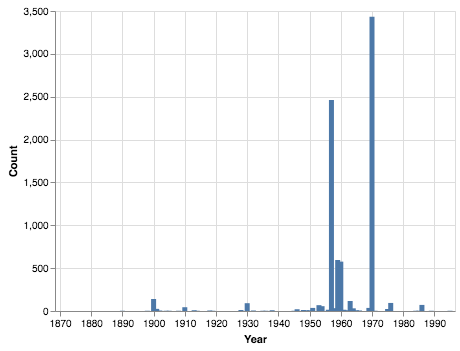

In [316]:
c1 = alt.Chart(years).mark_bar().encode(
    x='Year:T',
    y='Count',
    tooltip=[alt.Tooltip('Year:T', format='%Y'), 'Count']
).interactive()
c1

Hmmm, the values for 1957 and 1970 are a bit extraordinary. I wonder what's going on...?

## What happened in 1970?

I'd hoped to try and find out what happened in 1970 by limiting the results to those with a `createdDate` of '1970-01-01'. I first tried this query using `filters` to set the value for `production.createdDate`. However, the request returned an error that said the field wasn't facetable. I then tried adding `production.createdDate:"1970-01-01"` to the query string but then I go no results at all. Eventually I found this [in the docs](https://github.com/te-papa/collections-api/wiki/Getting-started):

> Field search is not possible against nested fields, for example collection:Art is possible, but not production:mccahon or production.contributor.title:mccahon (however all nested text is searchable in general searches)

So I think I'll need to harvest all the photographs data and then explore offline. That'll have to wait...

## What are the photos about?

Let's try another approach. The `depicts` field provides a list of subjects (which I think could themselves be people, places, or categories). By asking for facets from the `depicts` field, we could get a picture of what the photos are about.

At first I tried getting facets for `depicts.title`, but this didn't work as `title` is a text field. After a bit of trial and error, I realised that asking for facets on `depicts.href` produced useful results. The `href` field is the API link to the full record for the category, so not only does it give us facets, it provides a link to get more information.

#### The POST data

In [278]:
post_data = {
    'query': 'chinese',
    'filters': [{
        'field': 'collection',
        'keyword': 'Photography'
    }],
    'facets': [
        {'field': 'depicts.href',
        'size': 10}
    ]
}

#### The API response

In [279]:
# Get the API response
response = requests.post(search_endpoint, json=post_data, headers=headers)
data = response.json()

#### Convert the results to a dataframe

In [280]:
depicts_df = pd.DataFrame(list(data['facets']['depicts.href'].items()))
depicts_df.columns = ['Category', 'Count']
depicts_df.head()

,Category,Count
0,https://data.tepapa.govt.nz/collection/categor...,167
1,https://data.tepapa.govt.nz/collection/categor...,176
2,https://data.tepapa.govt.nz/collection/categor...,345
3,https://data.tepapa.govt.nz/collection/categor...,161
4,https://data.tepapa.govt.nz/collection/categor...,241


#### Add category titles to the dataframe

So the `href` field by itself isn't very illuminating. But by looking it up using a simple GET request we get lots more data including the category title.

I thought this could be useful later on so I created a simple function.

In [281]:
def get_categories(df):
    '''
    Lookup category urls and get back the title to add to dataframe.
    '''
    for i in tnrange(len(df)):
        href = df.loc[i]['Category']
        response = requests.get(href, headers=headers)
        title = response.json()['title']
        df.at[i, 'Title'] = title
    return df

depicts_df = get_categories(depicts_df)
depicts_df

,Category,Count,Title
0,https://data.tepapa.govt.nz/collection/categor...,167,performing artists
1,https://data.tepapa.govt.nz/collection/categor...,176,People
2,https://data.tepapa.govt.nz/collection/categor...,345,Chinese
3,https://data.tepapa.govt.nz/collection/categor...,161,men
4,https://data.tepapa.govt.nz/collection/categor...,241,Motion picture industry
5,https://data.tepapa.govt.nz/collection/categor...,474,Japanese
6,https://data.tepapa.govt.nz/collection/categor...,157,actors
7,https://data.tepapa.govt.nz/collection/categor...,241,Motion pictures
8,https://data.tepapa.govt.nz/collection/categor...,245,Costumes
9,https://data.tepapa.govt.nz/collection/categor...,131,Men


#### Make a chart

Now we have the titles, let's make a bar chart.

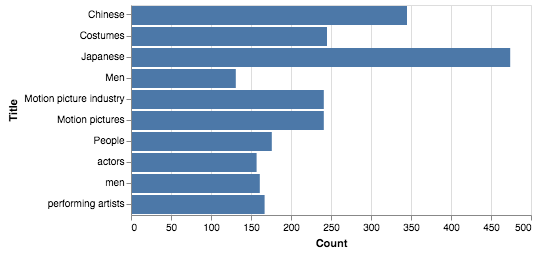

In [282]:
alt.Chart(depicts_df).mark_bar().encode(
    y='Title:O',
    x='Count',
    tooltip=['Count']
)

Hmmm... Of course we should remember that these are only the top 10 facets — we might want to expand the results. But already we can see a few oddities. For example, there's separate entries for 'Men' and 'men'!

Perhaps more interestingly, the most cited category in our search for 'Chinese' amongst photos in the Te Papa collection is 'Japanese'. That's weird...

## Why do so many photographs in my search for 'Chinese' have the category 'Japanese'?

Let's see if we can find out what's going on. First of all, let's try to limit our results to those that cite the 'Japanese' category. Filtering on the category `href` value seems to work.

#### Get the 'Japanese' category href value

In [283]:
href = depicts_df.loc[depicts_df['Title'] == 'Japanese']['Category'].values[0]
href

'https://data.tepapa.govt.nz/collection/category/417'

#### The POST data

In [284]:
post_data = {
    'query': 'chinese',
    'filters': [
        {
            'field': 'collection',
            'keyword': 'Photography'
        },
        {
            'field': 'depicts.href',
            'keyword': href
        }
    ]
}

#### The API response

In [285]:
# Get the API response
response = requests.post(search_endpoint, json=post_data, headers=headers)
data = response.json()

#### View the titles

Let's just loop through the results and list the titles.

In [286]:
for result in data['results']:
    print(result['title'])

Japan series: boats
Japan series: women mourning
Japan series: Hokkaido, Furubira winter fishing port
Japan Series: Honda Factory
Girls cheer teenage idol Akira Mitsu, Noda, Japan. Taken for a series on Japan for ‘Life’
Japan Series: Daiei Movie
A typical Japanese farmer in Rain Coat and Hat
Japanese Rice Planters at Dinner - Eating Rice, Japan
On the Way to the Bridegroom's House
One of Japan's Largest Modern Silk Weaving Plants - American Machinery and American Methods, Kirju, Japan


Hmmm... Ok, so we can see why they have the 'Japanese' category attached, but why do they come up in a search for 'Chinese'?

#### Finding the references to our keyword

From the raw results it's pretty hard to see why these photos are appearing in our search. The function below loops through all the nested records in the data looking for occurances of our keyword.

In [287]:
def find_fields(doc, keyword):
    '''
    Find fields that contain the given keyword.
    Return the name of the field and the parent object.
    '''
    if isinstance(doc, list):
        for d in doc:
            for result in find_fields(d, keyword):
                yield result
    if isinstance(doc, dict):
        for k, v in iteritems(doc):
            if isinstance(v, str) and keyword in v:
                yield [doc, k]
            elif isinstance(v, dict):
                for result in find_fields(v, keyword):
                    yield result
            elif isinstance(v, list):
                for d in v:
                    for result in find_fields(d, keyword):
                        yield result

fields = list(find_fields(data['results'], keyword))

Now let's list the results, displaying the type of record the keyword appears in (Object, Place, Category etc), the title of the record, and the context in which the keyword appears.

In [288]:
for field in fields:
    print('\n{} -- {}'.format(field[0]['type'], field[0]['title']))
    context = re.search('(.{{0,40}}{}.{{0,40}})'.format(keyword), field[0][field[1]]).group(1)
    print(context.replace(keyword, '\33[43m{}\033[0m'.format(keyword)))


Place -- Japan
ry BCE; adopted handwriting and much of Chinese culture in the 6th-9th centuries. The e

Place -- Japan
ry BCE; adopted handwriting and much of Chinese culture in the 6th-9th centuries. The e

Place -- Japan
ry BCE; adopted handwriting and much of Chinese culture in the 6th-9th centuries. The e

Place -- Japan
ry BCE; adopted handwriting and much of Chinese culture in the 6th-9th centuries. The e

Place -- Japan
ry BCE; adopted handwriting and much of Chinese culture in the 6th-9th centuries. The e

Place -- Japan
ry BCE; adopted handwriting and much of Chinese culture in the 6th-9th centuries. The e

Place -- Japan
ry BCE; adopted handwriting and much of Chinese culture in the 6th-9th centuries. The e

Place -- Japan
ry BCE; adopted handwriting and much of Chinese culture in the 6th-9th centuries. The e

Place -- Japan
ry BCE; adopted handwriting and much of Chinese culture in the 6th-9th centuries. The e

Place -- Japan
ry BCE; adopted handwriting and much of Chinese 

So what's going on? From the list above you can see that the reference to 'Chinese' comes from a linked record for the `Place` 'Japan'. The default `query` search looks in all nested text fields, including the `scopeNote` of linked `Place` records, which is where the text above comes from.

On the one hand it's great that the default search looks in all the nested records. But on the other hand it's a bit annoying, because if we want to do anything with the data we'll have to weed out the irrelevant photos. It's a familiar trade-off between discoverability and accuracy. In a web interface it's good to include as much as possible and then relevance rank it in a sensible way. This gives users their best chance of finding what they're after. But it's not so good if you're using an API to assemble a dataset for further analysis. In that case you want to be able to set fairly firm boundaries around your results.

## Can we exclude results citing the 'Japanese' category?

Is there a way of excluding categories from our results. Well, sort of... If we try to filter by the `depicts.href` field we run into the same problem with nested field searching as we did with the dates. But unlike a date string, the category `href` value is pretty specific, so we could probably just through it in the `query` string.

#### Get the 'Japanese' category href value

In [289]:
href = depicts_df.loc[depicts_df['Title'] == 'Japanese']['Category'].values[0]
href

'https://data.tepapa.govt.nz/collection/category/417'

#### The POST data

In [290]:
post_data = {
    'query': 'chinese -"{}"'.format(href),
    'filters': [
        {
            'field': 'collection',
            'keyword': 'Photography'
        }
    ],
    'facets': [
        {'field': 'depicts.href',
        'size': 10}
    ]
}

#### The API response

In [291]:
# Get the API response
response = requests.post(search_endpoint, json=post_data, headers=headers)
data = response.json()

#### How many results do we have now?

In [292]:
data['_metadata']['resultset']

{'count': 8447, 'from': 0, 'size': 10, 'truncated': False}

If we look above, we can see we started with 8,920 photos. The 'Japanese' category had 474 results. So I expected we'd have:

    8,920 - 474 = 8,446 results

One off...

## What's next?

I've had a go at [making maps](Mapping-Te-Papa-collections.ipynb) from some other facets. I think next I want to try harvesting out significant amounts of data. Stay tuned...